In [1]:
from crystalbuilder import *
import crystalbuilder.geometry as geo
import matplotlib.pyplot as plt
import numpy as np
import vedo

Error: Lumpy and/or the Lumerical API were not found.


This notebook combines our square lattice example and our core-shell example. 

We'll use our cubic lattice, just like before:

In [2]:
a1 = [1, 0, 0]
a2 = [0, 1 ,0]
a3 = [0, 0, 1]

a_mag = 1

geo_lattice = lattice.Lattice(a1, a2, a3, magnitude = [a_mag, a_mag, a_mag])

We've now defined our lattice. It's important to note that this is a CrystalBuilder lattice and not an MPB one. They can be converted, as we will show later, but they are not the exact same. 

Let's get the positions of the "atoms" in the diamond lattice that our rods will connect.

The square diamond lattice looks like 4 tetrahedra connected to one another. There are 18 sites in the cubic unit cell. 

To avoid manually specifying those 18 sites, let's take advantage of the Bilbao Crystallographic Server. Fortunately, CrystalBuilder includes a package that can grab and parse the generators from [the Bilbao site](https://www.cryst.ehu.es). 
<br>
<summary>The Bilbao database is summarized in the following papers, which should be cited if this function is used. </summary>

<details>

>
>M. I. Aroyo, J. M. Perez-Mato, D. Orobengoa, E. Tasci, G. de la Flor, A. Kirov
"Crystallography online: Bilbao Crystallographic Server"
Bulg. Chem. Commun. 43(2) 183-197 (2011).
>
>M. I. Aroyo, J. M. Perez-Mato, C. Capillas, E. Kroumova, S. Ivantchev, G. Madariaga, A. Kirov & H. Wondratschek
"Bilbao Crystallographic Server I: Databases and crystallographic computing programs"
 Z. Krist. 221, 1, 15-27 (2006)
>
>M. I. Aroyo, A. Kirov, C. Capillas, J. M. Perez-Mato & H. Wondratschek
"Bilbao Crystallographic Server II: Representations of crystallographic point groups and space groups"
Acta Cryst. A62, 115-128 (2006)
>
</details>

The bilbao.SpaceGroup() class contains functions for applying symmetry operations to specified points. An instance of the space group must be initialized, with the only argument being the IUCr space group number (1-230).

After this, the calculate_points function will accept any number of input coordinates and perform all of the symmetry operations. The output will be either a numpy array (default) or a list. If using a numpy array, the output will contain only the unique results of the symmetry operations. A list will contain duplicates, as np.unique() requires a conversion to an ndarray. For this reason, it is strongly recommended to use the default numpy output.

In [6]:
diamond = bilbao.SpaceGroup(227)

pt = 0
position_shift = 1/8

points = diamond.calculate_points(point_list=(pt+position_shift, pt+position_shift, pt+position_shift)) #This is the 8a wyckoff position

print(points)
print(len(points))

positive: [[0.125 0.125 0.125]]
positive: [[0.625 0.125 0.625]]
positive: [[0.125 0.625 0.625]]
positive: [[0.625 0.625 0.125]]
positive: [[0.125 0.125 0.125]]
positive: [[0.625 0.625 0.125]]
positive: [[0.625 0.125 0.625]]
positive: [[0.125 0.625 0.625]]
positive: [[0.125 0.125 0.125]]
positive: [[0.125 0.625 0.625]]
positive: [[0.625 0.625 0.125]]
positive: [[0.625 0.125 0.625]]
positive: [[0.875 0.375 0.375]]
positive: [[-0.125 -0.125 -0.125]]
positive: [[0.375 0.375 0.875]]
positive: [[0.375 0.875 0.375]]
positive: [[0.875 0.375 0.375]]
positive: [[0.375 0.875 0.375]]
positive: [[-0.125 -0.125 -0.125]]
positive: [[0.375 0.375 0.875]]
positive: [[0.875 0.375 0.375]]
positive: [[0.375 0.375 0.875]]
positive: [[0.375 0.875 0.375]]
positive: [[-0.125 -0.125 -0.125]]
positive: [[-0.125 -0.125 -0.125]]
positive: [[0.375 0.875 0.375]]
positive: [[0.875 0.375 0.375]]
positive: [[0.375 0.375 0.875]]
positive: [[-0.125 -0.125 -0.125]]
positive: [[0.375 0.375 0.875]]
positive: [[0.375 0.875 0

For a diamond lattice, the rods connect nearest-neighbor points. Using geo.NearestNeighbors, we can create cylinders between the points that are within a neighborhood_range of each other. The output is a list of geometries, which could be converted into a supercell if desired. 

<summary> Under the hood: </summary>
<details>
The details of this step involve creating a KDTree from the points, and calculating their distances in Euclidean space (Minkowski order 2). The neighborhood_range is in absolute coordinates and is not scaled to the lattice constant.
</details> 

In [4]:
radius = .12
shell_radius = .02
core_rods = geo.NearestNeighbors(points, radius=radius, neighborhood_range=.45)
shell_rods = geo.NearestNeighbors(points, radius=(radius+shell_radius), neighborhood_range=.45)

#sphere_caps = [geo.Sphere(center=point, radius=radius) for point in points]


Now lets use our previously defined lattice to tile these cylinders into a crystal.

In [5]:
a1_reps = 4
a2_reps = 4
a3_reps = 2
crystal_core = geo_lattice.tile_geogeometry(core_rods, a1_reps, a2_reps, a3_reps )
crystal_shell = geo_lattice.tile_geogeometry(shell_rods, a1_reps, a2_reps, a3_reps )

We can visualize this using CrystalBuilder's viewer package, which builds the structure as a Vedo scene. 

In [6]:
scene = viewer.visualize(crystal_core, c='white', res=5)
viewer.add_to_visualizer(crystal_shell, scene, c='red', alpha=.5, res=5)
scene.show().close()



# k=0
# string = f"square_diamond/group-object.obj"
# # vedo.write_group(objects, string)
# for obj in objects:
#     k+=1
#     string=f"square_diamond/thinunit-{k}.obj"
#     vedo.write(obj, string)


It looks good, so let's convert to MPB and simulate a band structure. Keep in mind that MPB does all of the tiling for you, so you do not need to use the results returned previously by `tile_geogeometry()`. Instead, you'll use the original unit cell that you defined. Here we used `core_rods` and `shell_rods`. We've kept them separate through now because we need to make them different materials.

In [7]:
import meep as mp
from meep import mpb

# Our two materials
febid_n = 1.5
si_n = 1

# Define them as MPB epsilons
febid_mat = mp.Medium(epsilon=(febid_n*febid_n))
si_mat = mp.Medium(epsilon=(si_n * si_n))

# Convert our defined lattice vectors and our unit cell to MPB
mpb_lattice = convert.to_mpb_lattice(geo_lattice)
core_geometry = convert.geo_to_mpb(core_rods, material=febid_mat, lattice=mpb_lattice)
shell_geometry = convert.geo_to_mpb(shell_rods, material=si_mat, lattice=mpb_lattice)

# combine our fully-defined elements, making sure that the core comes *after* the shell. The core will replace the shell where they overlap
mpb_geometry = shell_geometry + core_geometry

The above conversions are done by the CrystalBuilder convert module, and our output defines our mpb_lattice and our mpb_geometry

We then define our k points and other simulation parameters. Here we will plot the path Gamma-K-L-U-W-X, which follows from the Hinuma et al. Band Structure tables. 

In [8]:
vlist = [
    mp.Vector3(.5, 0.5, .5),          # L
    mp.Vector3(0, 0, 0),            # Gamma
    mp.Vector3(.5, 1, 0),    # W
    mp.Vector3(1,0, 0)        # X
    
]
k_corners = len(vlist)
k_points = mp.interpolate(5, vlist)
tick_labs = ['X','L', '\Gamma','X', 'W',]


resolution = 8 # use a 16x16x16 grid
mesh_size = 1
num_bands = 40

ms = mpb.ModeSolver(
    geometry_lattice=mpb_lattice,
    k_points=k_points,
    geometry=mpb_geometry,
    resolution=resolution,
    num_bands=num_bands,
    mesh_size=mesh_size
)

ms.run()

Initializing eigensolver data
Computing 40 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 8 x 8 x 8.
Solving for 10 bands at a time.
Creating Maxwell data...
Mesh size is 1.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0.75,0.75)
          radius 0.14, height 0.433013, axis (0.57735, -0.57735, -0.57735)
     cylinder, center = (0.75,0,0.75)
          radius 0.14, height 0.433013, axis (0.57735, -0.57735, 0.57735)
     cylinder, center = (0,0,0)
          radius 0.14, height 0.433013, axis (0.57735, 0.57735, 0.57735)
     cylinder, center = (0.5,0.75,0.25)
          radius 0.14, height 0.433013, axis (0.57735, -0.57735, -0.57735)
     cylinder, center = (0.75,0.25,0.5)
          radius 0.14, height 0.433013, axis (0.57735, 0.57735, -0.57735)
     cylinder, center = (0,0.5,0.5)
          radius 0.14, height 

epsilon: 1-2.25, mean 1.37259, harm. mean 1.21558, 56.25% > 1, 29.807% "fill"


real part range: 1 .. 2.25


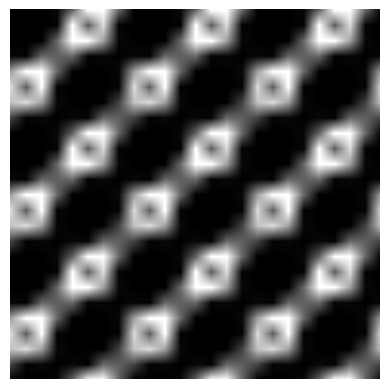

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (5).

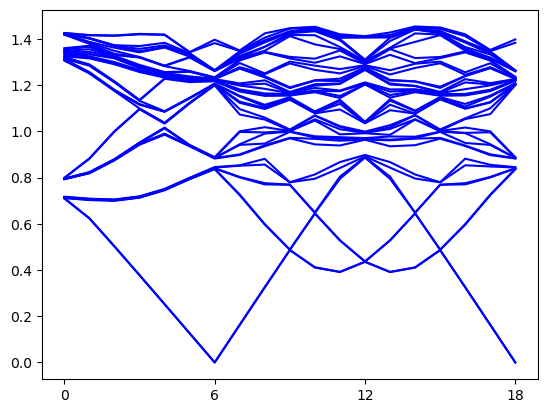

In [9]:
### Plotting Dielectric Map ###
plt.figure()
md = mpb.MPBData(rectify=False, periods=3, resolution=64)
eps = ms.get_epsilon()
converted_eps = md.convert(eps)
layer_slice = 11
plt.imshow(converted_eps[:,:, layer_slice], interpolation='spline36', cmap='binary_r')
plt.axis('off')
plt.show()

### Plotting Band Structure ###
crysfreqs = ms.all_freqs
x = range(len(crysfreqs))
figgy = plt.figure()
plt.plot(x,crysfreqs, color='blue');
points_in_between = (len(crysfreqs)-1) / (k_corners-1)
tick_locs = [i*points_in_between for i in range(k_corners)]

plt.xticks(tick_locs,tick_labs)
plt.ylabel('frequency (c/a)', size=16)
plt.grid(True)
figax = plt.gca()

plt.show()


Output the structure to an array for rebuilding via marching_cubes.

In [ ]:
filename = "DiamondLattice_Rebuilt"

np.save(filename, converted_eps)